Lambda School Data Science

*Unit 2, Sprint 4, Build*

# Business Question: 
## What is the value of fall detection in generating revenue?

# Business Answer: 
## It meets a need in a large demographic, as more and more baby boomers age out, they are more vulnerable to falls.  Revenue can be generated through devices, machine learning model expertise and subject matter expertise.





## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation. *Check*
- [ ] Make multiple PDPs with 2 features in interaction. *Check*
- [ ] Use Plotly to make a 3D PDP. 
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.*Check*

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.*I did not understand this one, a Confusion Matrix?*
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

In [650]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/jraval/Unit2BuildProjectLambda/main/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [651]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [652]:
import io
from io import BytesIO
!pip install zipfile36

In [653]:
import zipfile

In [654]:
!pip install xgboost

In [655]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


# **Boosting and Permutation Importance**

- Use XGBoost for **gradient boosting**
- Get **permutation importances** for model interpretation and feature selection 

## **Wrangle Data**

In [656]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [657]:
def wrangle(X):
    #Make a copy
    X = X.copy()
    #Drop high cardinality features
    high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]
    X.drop(columns = high_card_cols, inplace=True)
    
    return X

In [658]:
df.isna().sum()

importances_mean    0
importances_std     0
dtype: int64

In [659]:
# Read in data from your Build Week Dataset
fall_url = 'https://raw.githubusercontent.com/jraval/Unit2BuildProjectLambda/main/KaggleFallDetection_2_8_21.csv'



#df = pd.io.parsers.read_csv(fall_url, dtype={'https://github.com/jraval/Unit2BuildProjectLambda/blob/main/KaggleFallDetection_2_8_21_3.csv': 'str'})

In [660]:
df = pd.read_csv(fall_url)

In [661]:
df.head()

ACTIVITY     TIME        SL      EEG  BP   HR  CIRCLUATION
0         3  4722.92   4019.64 -1600.00  13   79          317
1         2  4059.12   2191.03 -1146.08  20   54          165
2         2  4773.56   2787.99 -1263.38  46   67          224
3         4  8271.27   9545.98 -2848.93  26  138          554
4         4  7102.16  14148.80 -2381.15  85  120          809

Your code starts here:

In [662]:
# Change column names: replace spaces with underscores
df.rename(columns={'CIRCLUATION':'CIRCULATION'}, inplace=True)

# EDA

(7.0, 0.0)

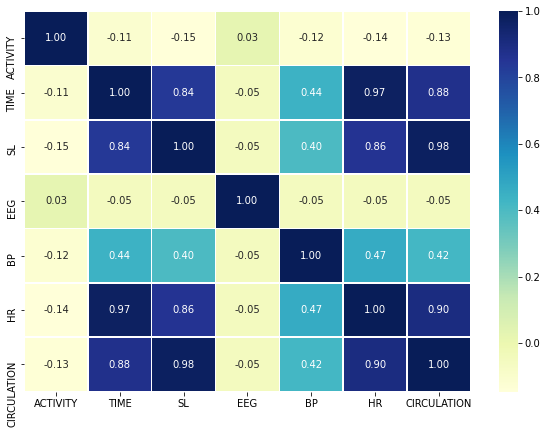

In [663]:
#I like this better than the correlation matrix in Pandas Profiling
#There are three correlation matrices in this notebook, the question is why

import seaborn as sns#EDA - determine which columns to drop, there was overfitting in train set

corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim()

In [664]:
# Get Pandas Profiling Report
import pandas as pd
import pandas_profiling

pandas_profiling.ProfileReport(df)

### Choose your target 

Which column in your tabular dataset will you predict?

I picked incidence of falls as my target because that is what the study was measuring, can we predict falling?

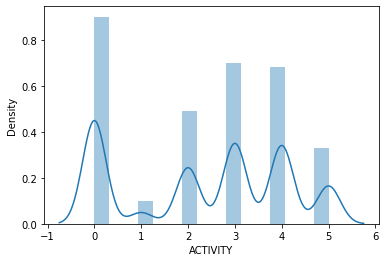

In [665]:
import seaborn as sns #There is no clear majority
import matplotlib.pyplot as plt
sns.distplot(df['ACTIVITY']);

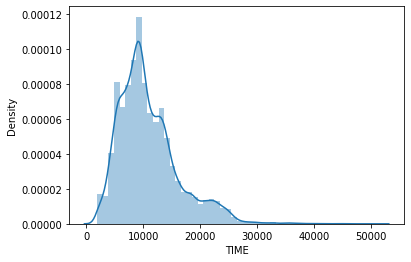

In [666]:
sns.distplot(df['TIME'], kde=True);#Time is skewed

*There is a right skew but the number of repeated rows is negligible.  See Pandas Profile Below:*

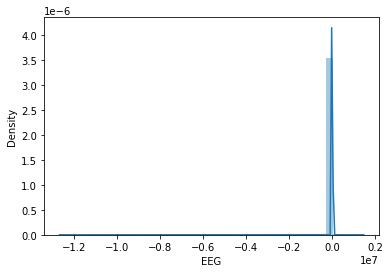

In [667]:
sns.distplot(df['EEG'], kde=True);#Time is skewed

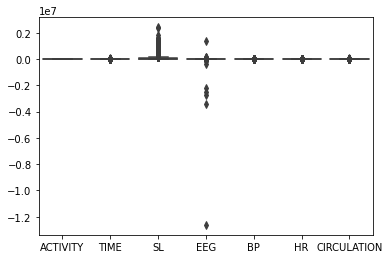

In [668]:
sns.boxplot(data=df);#SL and EEG have outliers

In [669]:
df = df[(df['EEG']< df['EEG'].quantile(0.999) ) & (df['EEG']> df['EEG'].quantile(0.001))]

In [670]:
df = df[(df['SL']< df['SL'].quantile(0.99) ) & (df['SL']> df['SL'].quantile(0.01))]

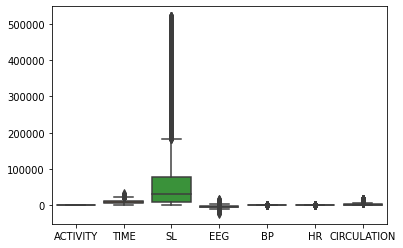

In [671]:
sns.boxplot(data=df);#For SL outliers, we cut the lowest and highest percent of the distribution and EEG no longer has outliers

In [672]:
pd.set_option('display.max_rows', 500)

In [673]:
df['TIME'].sample(100)#Checking to see duplicates or null values

13492    10006.90
3663      8395.77
4491      5778.22
13345     6272.70
2266      8447.87
11760    14734.90
8446      7187.85
7198      9966.61
2481      6576.78
3429      6874.98
7500      4699.26
13322     6532.65
14717     7261.38
15272    18545.80
2783     12313.50
13212     8469.56
15535     5380.23
7308      9622.82
10612     7813.67
12728     9375.63
10206     8209.64
7385      5633.88
4726      6822.74
1643      9791.21
80        5757.49
8035      5813.62
15480    11018.30
15280     8744.24
11739     9161.81
380       7929.02
969       7397.18
13260    15228.20
3852     14115.60
8402      4216.26
342       6790.71
13432     6863.11
14467     7489.60
2015     15503.00
13822     5029.21
12011    14931.70
2111      7477.06
13784     4475.62
1429      4002.39
12541     8301.79
14153     8596.63
5528     14445.10
6746     10645.40
12890    20453.60
9153      7100.89
14535     8851.16
12387     6349.92
5735      8737.72
9286      6929.16
7354      4995.89
2715      8692.96
6345     2

In [674]:
df['TIME'].value_counts()

9747.05     3
13733.80    3
10844.00    3
12912.20    3
12894.80    3
           ..
11713.70    1
14488.00    1
3867.57     1
10146.00    1
5271.62     1
Name: TIME, Length: 15649, dtype: int64

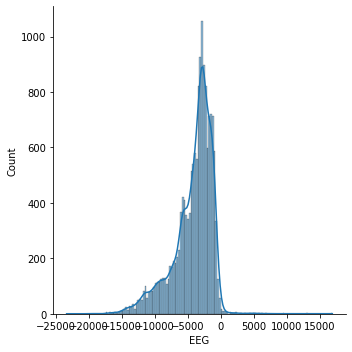

In [675]:
sns.displot(df['EEG'], kde=True);

The Key for values

0- Standing
1- Walking
2- Sitting
3- Falling
4- Cramps
5- Running

In [676]:
y = df['ACTIVITY']#As we can see there is no clear majority class, standing has the largest plurality
y.nunique()
y.value_counts(normalize=True)

0    0.276717
3    0.222160
4    0.215793
2    0.153808
5    0.105243
1    0.026280
Name: ACTIVITY, dtype: float64

In [677]:
df.columns

Index(['ACTIVITY', 'TIME', 'SL', 'EEG', 'BP', 'HR', 'CIRCULATION'], dtype='object')

In [678]:
# Add an OLS (Ordinary Least Squares) trendline,
# to see how the outliers influence the "line of best fit"
import plotly.express as px


In [679]:
px.scatter(df, x= 'SL', y='CIRCULATION', trendline='ols')

In [680]:
df=df.fillna('Missing') #I may get rid of this line when I add an imputer, really not needed we proved there's no missing values earlier

# Pick Target, begin feature selection

In [681]:
df['FALLS'] = df['ACTIVITY']  #I'm expecting overfitting if I use these features because they were part of the same column, these features are essentially tied together.
df['STANDING'] = df['ACTIVITY']
df['WALKING'] = df['ACTIVITY']
df['SITTING'] = df['ACTIVITY']
df['CRAMPS'] = df['ACTIVITY']
df['RUNNING'] = df['ACTIVITY']

In [682]:
df = df.replace({'FALLS':{3:1, 1:0, 2:0, 4:0, 5:0}})
df = df.replace({'STANDING':{0:1, 1:0, 2:0, 3:0, 4:0, 5:0}})
df = df.replace({'WALKING':{2:0, 3:0, 4:0, 5:0}})
df = df.replace({'SITTING':{1:0, 2:1, 3:0, 4:0, 5:0,}})
df = df.replace({'CRAMPS':{1:0, 2:0, 3:0, 4:1, 5:0}})
df = df.replace({'RUNNING':{1:0, 2:0, 3:0, 4:0, 5:1}})

In [683]:
#df = df.replace({'FALLS':{0:2, 1:0}})  I wanted to see if flipping the values for falls makes any 
#                                      difference on metrics outside of the Confusion Matrix, it doesn't.
#df = df.replace({'FALLS':{2:1}})

In [684]:
df['STANDING'].value_counts(normalize=True)

0    0.723283
1    0.276717
Name: STANDING, dtype: float64

In [685]:
df

ACTIVITY     TIME        SL      EEG  BP   HR  CIRCULATION  FALLS  \
0             3  4722.92   4019.64 -1600.00  13   79          317      1   
1             2  4059.12   2191.03 -1146.08  20   54          165      0   
2             2  4773.56   2787.99 -1263.38  46   67          224      0   
3             4  8271.27   9545.98 -2848.93  26  138          554      0   
4             4  7102.16  14148.80 -2381.15  85  120          809      0   
...         ...      ...       ...      ...  ..  ...          ...    ...   
16377         4  9280.68  11417.00 -3021.64  36  156          654      0   
16378         3  8479.69   9455.54 -2932.85  17  138          554      1   
16379         2  8872.53  27449.90 -2870.00  33  156         1364      0   
16380         4  7738.99  26466.40 -2920.24  97  156         1521      0   
16381         3  9368.34  39149.10 -2970.00  21  196         1885      1   

       STANDING  WALKING  SITTING  CRAMPS  RUNNING  
0             0        0        0       0        0  
1             0        0        1       0        0  
2             0        0        1       0        0  
3             0        0        0       1        0  
4             0        0        0       1        0  
...         ...      ...      ...     ...      ...  
16377         0        0        0       1        0  
16378         0        0        0       0        0  
16379         0        0        1       0        0  
16380         0        0        0       1        0  
16381         0        0        0       0        0  

[16020 rows x 13 columns]

In [686]:
df['FALLS'].value_counts(normalize=True)

0    0.77784
1    0.22216
Name: FALLS, dtype: float64

In [687]:
build_df = df

In [688]:
px.scatter(build_df, x= 'BP', y='FALLS', trendline='ols')# Clearly binary, yet logistic regression is not the best model as we'll see below.

In [689]:
target = 'FALLS'

(13.0, 0.0)

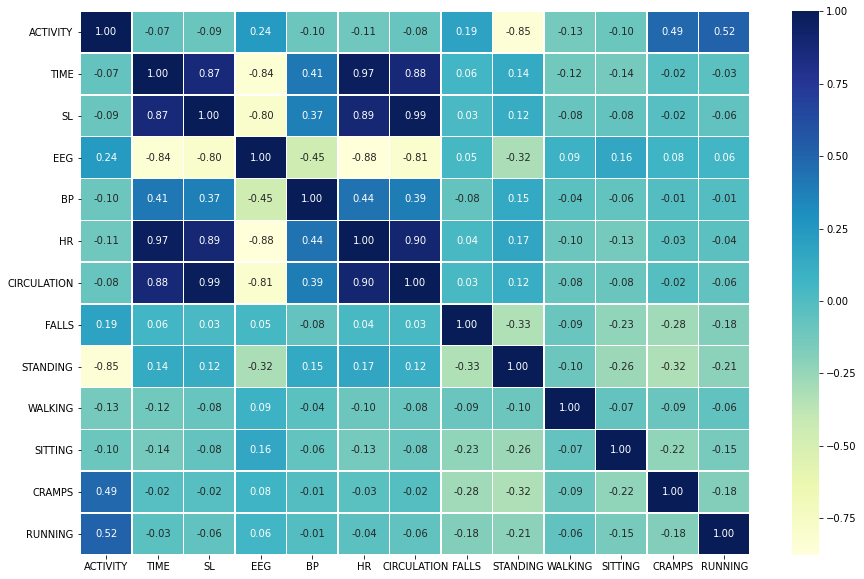

In [690]:
#EDA - determine which columns to drop, there was overfitting in train set
corr_matrix = build_df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim()

In [691]:
from scipy.stats import chi2_contingency
import numpy as np




def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [692]:
#Using Cramer's V we still see a high correlation between sugar load and circulation

SL_var = df['SL']
CIRCULATION_var = df['CIRCULATION']

cramers_V(SL_var, CIRCULATION_var)

0.9878358762203764

In reference to the cell below, I was checking to see that the build_df has not been overwritten from previous runs.  In addition, the cells below are determining to see if there is a correlation between the FALLS and WALKING columns.  There does not seem to be a correlation there.   

In [693]:
build_df.columns

Index(['ACTIVITY', 'TIME', 'SL', 'EEG', 'BP', 'HR', 'CIRCULATION', 'FALLS',
       'STANDING', 'WALKING', 'SITTING', 'CRAMPS', 'RUNNING'],
      dtype='object')

In [694]:
FALLS_var = build_df['FALLS']
WALKING_var = build_df['WALKING']
cramers_V(FALLS_var, WALKING_var)

0.007626136366500305

In [695]:
FALLS_var = build_df['FALLS']
STANDING_var = build_df['STANDING']
cramers_V(FALLS_var, WALKING_var)

0.007626136366500305

In [696]:
build_df = build_df.drop(columns=['ACTIVITY', 'WALKING', 'SITTING', 'CRAMPS', 'RUNNING', 'STANDING', 'TIME'])
build_df_2 = df.drop(columns=['ACTIVITY', 'WALKING', 'SITTING', 'CRAMPS', 'RUNNING', 'STANDING'])

(6.0, 0.0)

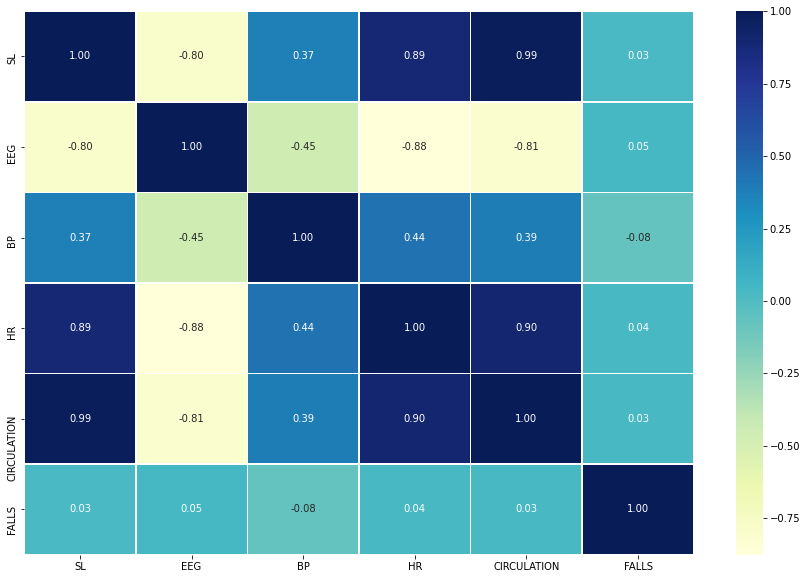

In [697]:
import seaborn as sns #EDA - determine which columns to drop, there was overfitting in train set, circulation should be dropped but I'm leaving it for now.

corr_matrix = build_df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim()

In [698]:
#from pdpbox.pdp import pdp_interact, pdp_interact_plot
#
#features =['FALLS', 'HR']
#
#interact = pdp_interact(
#    model = model_xgb,
#    dataset=build_df,
#    model_features=build_df.columns,
#    features=features
#)
#
#pdp_interact_plot(interact, plot_type='grid', feature_names=features);

#Split Train, Val, Test, Create Feature Matrix and Target

In [699]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [700]:
#build_df = wrangle(build_df) Not needed wrangle function was for high cardinality and all features were low cardinal

In [701]:
# Split train into train & test. Make val the same size as test.
target = 'FALLS'
train, test = train_test_split(build_df, test_size=0.2,  
                              stratify=build_df[target], random_state=42)

In [702]:
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [703]:
val.head()

SL       EEG  BP   HR  CIRCULATION  FALLS
14992  1867.97  -615.751  14   43          161      0
4188   7590.46 -1856.070  75  104          457      0
12723  9441.77 -2471.400  18  123          621      1
1528   7401.87 -1576.640  51   93          545      1
3144   7496.42 -2039.470  77  104          457      0

In [704]:
test.head()

SL       EEG  BP   HR  CIRCULATION  FALLS
11261  140111.0  -6180.00  44  315         5844      1
606    262192.0 -12000.00  87  540         8870      0
3264    74795.2  -4110.00  30  249         3630      0
4005    36256.1  -3740.00  43  196         1997      0
9226    13804.6  -3008.47  15  148          729      1

In [705]:
train.shape, val.shape, test.shape

((9612, 6), (3204, 6), (3204, 6))

In [706]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]


In [707]:
X_train.columns


Index(['SL', 'EEG', 'BP', 'HR', 'CIRCULATION'], dtype='object')

# Baseline Accuracy


In [708]:
y_train.value_counts(normalize=True)

0    0.777882
1    0.222118
Name: FALLS, dtype: float64

In [709]:
y_train.value_counts(normalize=True).max()


0.7778818143986683

# Build Model


In [710]:
import category_encoders as ce

In [711]:
model_lr = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()   
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [712]:
print('Validation Accuracy:', model_lr.score(X_val,y_val))

Validation Accuracy: 0.7787141073657927


In [713]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from category_encoders import OneHotEncoder

In [714]:
model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(n_estimators=100,
                               max_depth=5,
                               random_state=42)
)

model_skgb.fit(X_train, y_train);

In [715]:

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=100,
                  subsample=0.5,
                  random_state=42,
                  max_depth = 10,
                  eval_metric='merror',
                  tree_method='hist',
                  n_jobs=11)
)

In [716]:
model_xgb_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRFClassifier(n_estimators=100,
                  random_state=42,
                  max_depth = 5,
                  eval_metric='merror',
                  n_jobs=11)
)

model_xgb_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbrfclassifier',
                 XGBRFClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bytree=1,
                                 eval_metric='merror', gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints='', max_delta_step=0,
                                 max_depth=5, min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=100,
                                 n_jobs=11, num_parallel_tree=100,
                                 objective='binary:logistic', random_state=42,
                                 reg_alpha=0, scale_pos_weight=1,
                                 tree_method='exact', validate_parameters=1,
                                 verbosit

In [717]:
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='merror',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=11, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.5, tree_method='hist',
                               validate_par

# Random Forest and Decision Tree modeling
 - pipeline = RandomForest
 - model = DecisionClassifier

In [718]:
pipeline = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, max_leaf_nodes=500)
)#Random Forest pipeline/model

In [719]:
model = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(strategy='median'),  
    DecisionTreeClassifier(max_depth=11)
)#Decision Tree Model


# Metrics 
- Random Forest -1
- Decision Tree -2

In [720]:
pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train)) #Train initially had leakage but I changed the max_depth
#Random Forest


print('Validation Accuracy', pipeline.score(X_val, y_val))#RF

print('Test Accuracy', pipeline.score(X_test, y_test))#RF

Train Accuracy 0.8743237619642114
Validation Accuracy 0.8330212234706617
Test Accuracy 0.8342696629213483


In [721]:
model.fit(X_train, y_train)

print('Train Accuracy', model.score(X_train, y_train))#Decision Tree

print('Val Accuracy', model.score(X_val, y_val))#DT

print('Test Accuracy', model.score(X_test, y_test))#DTpipeline.fit(X_train, y_train)

Train Accuracy 0.8848314606741573
Val Accuracy 0.829900124843945
Test Accuracy 0.8186641697877652


# Hyperparameter Randomized CV Search

In [722]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [723]:
param_dist = {
    'randomforestclassifier__max_depth': range(5,36,10),
    'randomforestclassifier__n_estimators': [25,50,75],
    'randomforestclassifier__max_features': np.arange(0.2,0.8,0.2)
}

In [724]:
model_RCV = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=5,
    n_jobs=-1,
    cv=5,
    random_state =42,
    verbose=1
)

In [725]:
model_RCV.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(cols=[])),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(max_depth=10,
                                                                     max_leaf_nodes=500,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 36, 10),
                                        'randomforestclassifier__max_features': array([0.2, 0.4, 0.6, 0.8]),
                                        'randomforestclassifier__n_estimators': [25,
                 

In [726]:
model_RCV.best_score_

0.848105549612203

In [727]:
model_RCV.score(X_train, y_train)

0.951310861423221

In [728]:
#score on validation set 
model_RCV.score(X_val, y_val)

0.8579900124843945

In [729]:
model_RCV.score(X_test, y_test)

0.8470661672908864

In [730]:
#eval_set = [(X_val, y_val)]
#model_xgb = make_pipeline(
#    OrdinalEncoder(),
#    SimpleImputer(),
#    XGBClassifier(n_estimators=400,
#                  random_state=42, 
#                  eval_set=eval_set,
#                  eval_metric='merror',
#                  early_stopping_rounds=10,
#                  verbose=True,
#                  n_jobs=11)
#)

# BUILD MODEL FOR PDP PLOT and VISUALIZATIONS

In [731]:
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


encoder = ce.OrdinalEncoder()
imputer = SimpleImputer()
scaler = StandardScaler()
model_shap = RandomForestClassifier()

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model_shap.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Validation Accuracy', model_shap.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model_shap.predict(X_test_scaled)

Validation Accuracy 0.8573657927590512


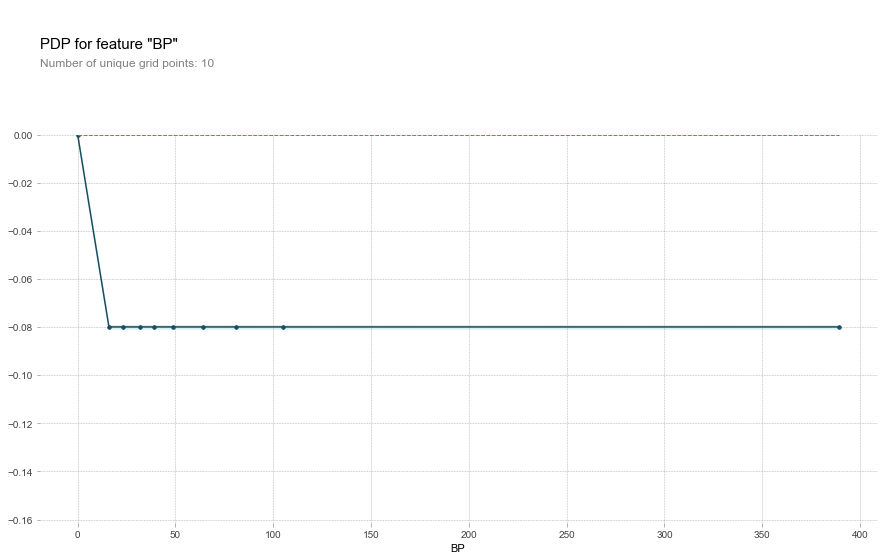

In [732]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'BP'

#Isolate

isolated = pdp_isolate(
    model=model_shap,
    dataset=X_test, # <--- Always use validation or test data
    model_features=X_test.columns,
    feature=feature,
    #num_grid_points=50
    
)

pdp_plot(isolated, feature_name=feature);

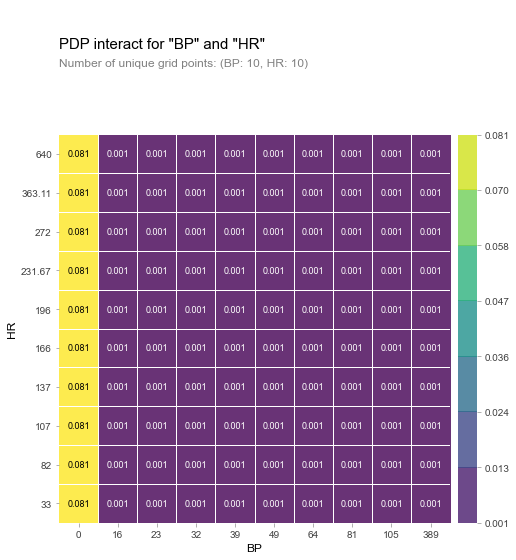

In [733]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features =['BP', 'HR']

interact = pdp_interact(
    model = model_shap,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [734]:
# Grab a single observation of test data

row = X_train.iloc[[2]]

row

SL      EEG  BP   HR  CIRCULATION
2554  11195.3 -1893.42  24  102          764

In [735]:
# Grab a single observation of test data

row = X_train.iloc[[0]]

row

SL     EEG  BP   HR  CIRCULATION
9652  70134.0 -4904.0  20  254         3618

In [736]:
model_shap.predict(row)

array([0], dtype=int64)

In [737]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.78611	validation_1-auc:0.76969
[1]	validation_0-auc:0.81255	validation_1-auc:0.79262
[2]	validation_0-auc:0.83329	validation_1-auc:0.80844
[3]	validation_0-auc:0.84209	validation_1-auc:0.81465
[4]	validation_0-auc:0.85082	validation_1-auc:0.82174
[5]	validation_0-auc:0.86341	validation_1-auc:0.83697
[6]	validation_0-auc:0.87828	validation_1-auc:0.84981
[7]	validation_0-auc:0.88710	validation_1-auc:0.85664
[8]	validation_0-auc:0.88832	validation_1-auc:0.85755
[9]	validation_0-auc:0.88968	validation_1-auc:0.85767
[10]	validation_0-auc:0.89971	validation_1-auc:0.86667
[11]	validation_0-auc:0.90216	validation_1-auc:0.86762
[12]	validation_0-auc:0.90381	validation_1-auc:0.86868
[13]	validation_0-auc:0.90708	validation_1-auc:0.87066
[14]	validation_0-auc:0.91472	validation_1-auc:0.87615
[15]	validation_0-auc:0.91514	validation_1-auc:0.87596
[16]	validation_0-auc:0.91802	validation_1-auc:0.87632
[17]	validation_0-auc:0.91856	validation_1-auc:0.87687
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [738]:
# STUDY/PRACTICE THIS CELL FOR THE SPRINT CHALLENGE

!pip install shap
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

# **Check Metrics**

In [739]:
#FOR SPRINT CHALLENGE - DISREGARD
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.9060028608400815


In [740]:
print('sklearn Training Accuracy:', model_skgb.score(X_train, y_train))
print('sklearn Val Accuracy:', model_skgb.score(X_val, y_val))
print('sklearn Val Accuracy:', model_skgb.score(X_test, y_test))

sklearn Training Accuracy: 0.8801498127340824
sklearn Val Accuracy: 0.8411360799001248
sklearn Val Accuracy: 0.8455056179775281


In [741]:
print('sklearn Training Accuracy:', model_xgb.score(X_train, y_train))
print('sklearn Val Accuracy:', model_xgb.score(X_val, y_val))

sklearn Training Accuracy: 0.9674365376612568
sklearn Val Accuracy: 0.8411360799001248


In [742]:
print('sklearn Training Accuracy:', model_xgb_rf.score(X_train, y_train))
print('sklearn Val Accuracy:', model_xgb_rf.score(X_val, y_val))

sklearn Training Accuracy: 0.7965043695380774
sklearn Val Accuracy: 0.7949438202247191


# **Communicate Results**

- How can we determine or communicate which features are most important to our model when making predictions.

**Option 1 Grab feature importances from our pipeline**

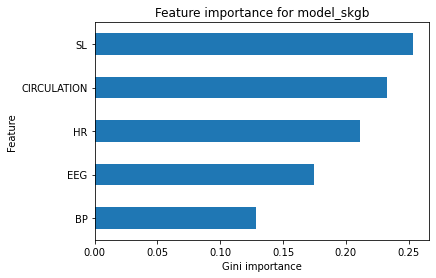

In [743]:
importances = model_skgb.named_steps['gradientboostingclassifier'].feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini importance')
plt.ylabel('Feature')
plt.title('Feature importance for model_skgb');

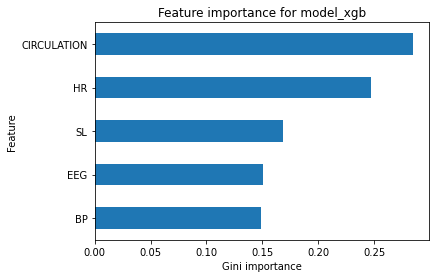

In [744]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini importance')
plt.ylabel('Feature')
plt.title('Feature importance for model_xgb');

**Option 2** Drop column importance
- Good, but computationally expensive, because you have to train a model for each feature

In [745]:
#Step 1 - Train a model for a feature we want to evaluate
feature = 'CIRCULATION'
feature_2 = 'HR'
feature_3 = 'SL'
feature_4 = 'EEG'
feature_5 = 'BP'

model_w_feat =  make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=10,
                  random_state=42, 
                  n_jobs=-1)
)

In [746]:
model_w_feat.fit(X_train, y_train);

[02:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [747]:
print(f'TrainAccuracy w {feature} included: ',model_w_feat.score(X_train, y_train))

TrainAccuracy w CIRCULATION included:  0.8358302122347067


In [748]:
print(f'ValAccuracy w {feature} included: ', model_w_feat.score(X_val, y_val)) #Use validation data

ValAccuracy w CIRCULATION included:  0.8174157303370787


In [749]:
#Step 2 - Train model without feature included
model_wo_feat =  make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=10,
                  random_state=42, 
                  n_jobs=-1)
)

model_wo_feat.fit(X_train.drop(columns=feature), y_train)


[02:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=10,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None

In [750]:
print(f'TrainAccuracy wo "{feature}"  not included: ', model_wo_feat.score(X_train.drop(columns=feature), y_train))

print(f'ValAccuracy wo "{feature}" not included: ', model_wo_feat.score(X_val.drop(columns=feature), y_val))

TrainAccuracy wo "CIRCULATION"  not included:  0.826883062838119
ValAccuracy wo "CIRCULATION" not included:  0.8108614232209738


In [751]:
model_wo_feat.fit(X_train.drop(columns=feature_2), y_train)
print(f'TrainAccuracy wo "{feature_2}"  not included: ', model_wo_feat.score(X_train.drop(columns=feature_2), y_train))
print(f'ValAccuracy wo "{feature_2}" not included: ', model_wo_feat.score(X_val.drop(columns=feature_2), y_val))

model_wo_feat.fit(X_train.drop(columns=feature_3), y_train)
print(f'TrainAccuracy wo "{feature_3}"  not included: ', model_wo_feat.score(X_train.drop(columns=feature_3), y_train))
print(f'ValAccuracy wo "{feature_3}" not included: ', model_wo_feat.score(X_val.drop(columns=feature_3), y_val))

model_wo_feat.fit(X_train.drop(columns=feature_4), y_train)
print(f'TrainAccuracy wo "{feature_4}"  not included: ', model_wo_feat.score(X_train.drop(columns=feature_4), y_train))
print(f'ValAccuracy wo "{feature_4}" not included: ', model_wo_feat.score(X_val.drop(columns=feature_4), y_val))

model_wo_feat.fit(X_train.drop(columns=feature_5), y_train)
print(f'TrainAccuracy wo "{feature_5}"  not included: ', model_wo_feat.score(X_train.drop(columns=feature_5), y_train))
print(f'ValAccuracy wo "{feature_5}" not included: ', model_wo_feat.score(X_val.drop(columns=feature_5), y_val))

model_wo_feat.fit(X_train.drop(columns=feature_2), y_train)
print(f'TrainAccuracy w "{feature_2}"  included: ', model_w_feat.score(X_train, y_train))
print(f'ValAccuracy w "{feature_2}" included: ', model_w_feat.score(X_val, y_val))

model_wo_feat.fit(X_train.drop(columns=feature_3), y_train)
print(f'TrainAccuracy w "{feature_3}"  included: ', model_w_feat.score(X_train, y_train))
print(f'ValAccuracy w "{feature_3}" included: ', model_w_feat.score(X_val, y_val))

model_wo_feat.fit(X_train.drop(columns=feature_4), y_train)
print(f'TrainAccuracy wo "{feature_4}"  included: ', model_w_feat.score(X_train, y_train))
print(f'ValAccuracy wo "{feature_4}" included: ', model_w_feat.score(X_val, y_val))

model_wo_feat.fit(X_train.drop(columns=feature_5), y_train)
print(f'TrainAccuracy w "{feature_5}" included: ', model_w_feat.score(X_train, y_train))
print(f'ValAccuracy w "{feature_5}" included: ', model_w_feat.score(X_val, y_val))

[02:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TrainAccuracy wo "HR"  not included:  0.8294839783603829
ValAccuracy wo "HR" not included:  0.8108614232209738
[02:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TrainAccuracy wo "SL"  not included:  0.83270911360799
ValAccuracy wo "SL" not included:  0.8177278401997503
[02:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric u

**Option 3 - Permutation Importance**

In [752]:
from numpy.random import permutation

#Our feature will still be 'CIRCULATION'

#Step 1 - Train the model on the whole dataset

feature = 'CIRCULATION'

model_xgb =  make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=10,
                  random_state=42, 
                  n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

#Step 2: Evaluate using the validation set
print('Validation Accuracy', model_xgb.score(X_val, y_val))


[02:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation Accuracy 0.8174157303370787


In [753]:
#In our Validation set, we're going to permute the feature we selected

X_val_perm = X_val.copy()
X_val_perm[feature] = permutation(X_val[feature])

In [754]:
X_val[feature].head()

14992    161
4188     457
12723    621
1528     545
3144     457
Name: CIRCULATION, dtype: int64

In [755]:
#Step 4 - Calculate the error metric with permuted data

print(f'Validation Accuracy with {feature} permuted', model_xgb.score(X_val_perm, y_val))

Validation Accuracy with CIRCULATION permuted 0.7506242197253433


In [756]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(model_xgb,
                                   X_val,
                                   y_val,
                                   n_jobs=1,
                                   random_state=42)

In [757]:
type(perm_imp)

sklearn.utils.Bunch

In [758]:
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [759]:
data = {'importances_mean' : perm_imp['importances_mean'], 'importances_std': perm_imp['importances_std']}

In [760]:
df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean',inplace=True)

In [761]:
df

importances_mean  importances_std
BP                   0.016105         0.003990
SL                   0.023096         0.003238
HR                   0.044132         0.003131
EEG                  0.054931         0.002225
CIRCULATION          0.070662         0.005497

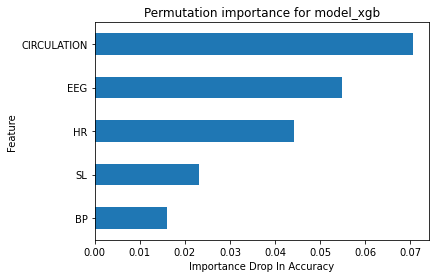

In [762]:
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance Drop In Accuracy')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

In [763]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, max_leaf_nodes=500,
                                        n_jobs=-1, random_state=42))])

In [764]:
model.fit(X_train, y_train)



[02:32:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [765]:
print('Train Accuracy', pipeline.score(X_train, y_train)) #Train initially had leakage but I changed the max_depth
#Random Forest

Train Accuracy 0.8743237619642114


In [766]:
print('Validation Accuracy', pipeline.score(X_val, y_val))#RF

Validation Accuracy 0.8330212234706617


In [767]:
print('Test Accuracy', pipeline.score(X_test, y_test))#RF


Test Accuracy 0.8342696629213483


In [768]:
print('Train Accuracy', model.score(X_train, y_train))#Decision Tree

Train Accuracy 0.9174989596337911


In [769]:
print('Val Accuracy', model.score(X_val, y_val))#DT

Val Accuracy 0.8486267166042447


# Baseline

In [770]:
y_test.value_counts(normalize=True).max(), y_val.value_counts(normalize=True).max()

(0.7777777777777778, 0.7777777777777778)

# Confusion Matrix

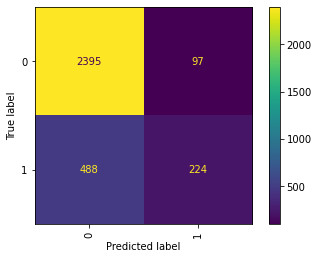

In [771]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_xgb, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [772]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2492
           1       0.22      0.19      0.20       712

    accuracy                           0.67      3204
   macro avg       0.50      0.50      0.50      3204
weighted avg       0.65      0.67      0.66      3204



# ROC-AUC Score probability for the last class

In [773]:
from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_val)[:,-1] # probability for the last class 
print('Val Score Decision Tree:', roc_auc_score(y_val, y_pred_proba))


Val Score Decision Tree: 0.903803688657637


In [774]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [775]:
#See the details in a table
pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds 
})

False Positive Rate  True Positive Rate  Threshold
0               0.000000            0.000000   1.975929
1               0.000000            0.001404   0.975929
2               0.000000            0.012640   0.970339
3               0.000000            0.015449   0.967323
4               0.000000            0.019663   0.963342
..                   ...                 ...        ...
969             0.990770            1.000000   0.001287
970             0.991573            1.000000   0.001221
971             0.993178            1.000000   0.000892
972             0.993981            1.000000   0.000890
973             1.000000            1.000000   0.000444

[974 rows x 3 columns]

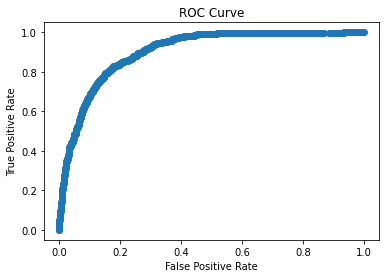

In [776]:
#See the details in a plot
#This is the Receiver Operating Characteristic curve
plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [777]:
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:,-1] # probability for the last class 
print('Val Score Random Forest:', roc_auc_score(y_val, y_pred_proba))


Val Score Random Forest: 0.8933260591195196


# Quick EDA on target


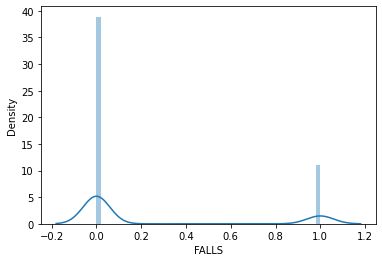

In [778]:
y = build_df['FALLS']
sns.distplot(y);
